
# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science

## Homework 4: Logistic Regression

**Harvard University**<br/>
**Fall 2019**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, and Chris Tanner

<hr style="height:2pt">



In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- **This is an individual homework. No group collaboration.**
- To submit your assignment, follow the instructions given in Canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and are aiming to teach. And if a problem specifies a particular library, you're required to use that library, and possibly others from the import list.
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed or otherwise limited. 

In [2]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LassoCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import zipfile


import seaborn as sns
sns.set()

from scipy.stats import ttest_ind

<div class='theme'> Cancer Classification from Gene Expressions </div>

In this problem, we will build a classification model to distinguish between two related classes of cancer, acute lymphoblastic leukemia (ALL) and acute myeloid leukemia (AML), using gene expression measurements. The dataset is provided in the file `data/dataset_hw4.csv`. Each row in this file corresponds to a tumor tissue sample from a patient with one of the two forms of Leukemia. The first column contains the cancer type, with **0 indicating the ALL** class and **1 indicating the AML** class. Columns 2-7130 contain expression levels of 7129 genes recorded from each tissue sample. 

In the following questions, we will use linear and logistic regression to build classification models for this data set. 


<div class='exercise'><b> Question 1 [20 pts]: Data Exploration </b></div>

The first step is to split the observations into an approximate 80-20 train-test split.  Below is some code to do this for you (we want to make sure everyone has the same splits). Print dataset shape before splitting and after splitting. `Cancer_type` is our target column.


**1.1** Take a peek at your training set: you should notice the severe differences in the measurements from one gene to the next (some are negative, some hover around zero, and some are well into the thousands). To account for these differences in scale and variability, normalize each predictor to vary between 0 and 1. **NOTE: for the entirety of this homework assignment, you will use these normalized values, not the original, raw values**.


**1.2** The training set contains more predictors than observations. What problem(s) can this lead to in fitting a classification model to such a dataset? Explain in 3 or fewer sentences.


**1.3** Determine which 10 genes individually discriminate between the two cancer classes the best (consider every gene in the dataset).

Plot two histograms of best predictor -- one using the training set and another using the testing set. Each histogram should clearly distinguish two different `Cancer_type` classes.

**Hint:** You may use t-testing to make this determination: #https://en.wikipedia.org/wiki/Welch%27s_t-test .


**1.4** Using your most useful gene from the previous part, create a classification model by simply eye-balling a value for this gene that would discriminate the two classes the best (do not use an algorithm to determine for you the optimal coefficient or threshold; we are asking you to provide a rough estimate / model by manual inspection). Justify your choice in 1-2 sentences. Report the accuracy of your hand-chosen model on the test set (write code to implement and evaluate your hand-created model).

<hr> <hr>

<hr>

### Solutions

**The first step is to split the observations into an approximate 80-20 train-test split. Below is some code to do this for you (we want to make sure everyone has the same splits). Print dataset shape before splitting and after splitting. `Cancer_type` is our target column.**

In [3]:
np.random.seed(10)
df = pd.read_csv('data/hw4_enhance.csv', index_col=0)
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'Cancer_type'], 
                                                         df.Cancer_type, test_size=0.2, 
                                                         random_state = 109, 
                                                         stratify = df.Cancer_type)

In [4]:
print(df.shape)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(df.Cancer_type.value_counts(normalize=True))

(752, 7130)
(601, 7129) (151, 7129) (601,) (151,)
0.0    0.511968
1.0    0.488032
Name: Cancer_type, dtype: float64


**1.1 Take a peek at your training set: you should notice the severe differences in the measurements from one gene to the next (some are negative, some hover around zero, and some are well into the thousands). To account for these differences in scale and variability, normalize each predictor to vary between 0 and 1. **NOTE: for the entirety of this homework assignment, you will use these normalized values, not the original, raw values.**


In [5]:
#your code here
X_train.describe()

,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,AFFX-BioB-5_st,...,U48730_at,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at
count,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,...,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000,601.000000
mean,-115.860969,-160.846155,26.545301,209.733439,-248.992903,-405.422569,-24.135140,-188.491329,74.777098,97.436777,...,161.766492,707.377318,4.198787,421.466477,-50.023954,819.053113,329.803212,8.803791,507.250039,-24.377549
std,170.571929,188.676919,207.781982,202.987246,207.328054,261.112412,535.143398,163.077167,174.693115,358.897719,...,165.152970,526.644408,152.401188,589.914084,106.864078,814.898058,367.788891,85.397644,939.394188,71.102874
min,-894.789505,-1095.737090,-645.439001,-425.750627,-1154.285694,-1091.492494,-2066.516448,-728.996262,-770.025847,-1176.663615,...,-501.285884,-1010.430536,-447.077819,-1870.955269,-432.967768,-2151.593119,-651.051441,-255.419724,-2754.665185,-237.864216
25%,-222.586579,-270.502055,-95.000000,85.327810,-379.048622,-567.547758,-338.435164,-302.872287,-20.739507,-117.000000,...,67.861184,361.596510,-88.660905,88.409441,-105.000000,270.198265,90.825501,-40.391630,-50.785999,-73.000000
50%,-105.139096,-145.829450,21.183690,207.291048,-231.007621,-433.214742,-39.581881,-175.586059,90.170754,101.975176,...,153.253301,679.935520,9.960900,381.000000,-35.000000,749.281111,296.978609,7.968505,407.942117,-25.403427
75%,-4.789696,-40.599329,127.821586,331.277808,-116.000000,-252.587379,325.000000,-74.379003,190.551199,288.503617,...,263.112797,1076.075567,96.051876,720.339588,19.775025,1286.343005,521.096719,62.794411,1092.430279,19.740635
max,516.618491,384.626762,748.233182,1022.560525,308.876677,607.737258,1385.881293,263.634029,589.778466,1355.537180,...,686.321597,2522.188808,481.820516,3982.980299,215.047697,3743.264860,1996.244626,274.575647,3315.374276,224.773440


In [6]:
#your code here
min_vals = X_train.min()
max_vals = X_train.max()

X_train = (X_train - min_vals)/(max_vals - min_vals)
X_test = (X_test - min_vals)/(max_vals - min_vals)

**1.2 The training set contains more predictors than observations. What problem(s) can this lead to in fitting a classification model to such a dataset? Explain in 3 or fewer sentences.**

*your answer here*


p>>n - Linear Regression and Logisitic Regression does not work. We need to regularize or reduce dimensions. 

The training set is improper as it contains many more columns compared to number of samples. If we fit models to the given dataset, they will be highly overfitted. This is called the curse of dimensionality.

Multicollinearity

**1.3 Determine which 10 genes individually discriminate between the two cancer classes the best (consider every gene in the dataset).**

**Plot two histograms of best predictor -- one using the training set and another using the testing set. Each histogram should clearly distinguish two different `Cancer_type` classes.**

**Hint:** You may use t-testing to make this determination: #https://en.wikipedia.org/wiki/Welch%27s_t-test.

In [7]:
#your code here
predictors = df.columns
predictors = predictors.drop('Cancer_type');
print(predictors.shape) 

means_0 = X_train[y_train==0][predictors].mean()
means_1 = X_train[y_train==1][predictors].mean()
stds_0 = X_train[y_train==0][predictors].std()
stds_1 = X_train[y_train==1][predictors].std()
n1 = X_train[y_train==0].shape[0]
n2 = X_train[y_train==1].shape[0]

t_tests = np.abs(means_0-means_1)/np.sqrt( stds_0**2/n1 + stds_1**2/n2) 
#your code here
best_preds_idx = np.argsort(-t_tests.values)
best_preds = t_tests.index[best_preds_idx]

print(t_tests[best_preds_idx[0:10]])
print(t_tests.index[best_preds_idx[0:10]])

best_pred = t_tests.index[best_preds_idx[0]]
print(best_pred)

(7129,)
M31523_at         12.537397
X95735_at         12.435494
M84526_at         11.870642
X61587_at         11.458105
U50136_rna1_at    10.986655
X17042_at         10.666939
U29175_at         10.487500
Y08612_at         10.299221
Z11793_at         10.081967
X76648_at         10.024521
dtype: float64
Index(['M31523_at', 'X95735_at', 'M84526_at', 'X61587_at', 'U50136_rna1_at',
       'X17042_at', 'U29175_at', 'Y08612_at', 'Z11793_at', 'X76648_at'],
      dtype='object')
M31523_at


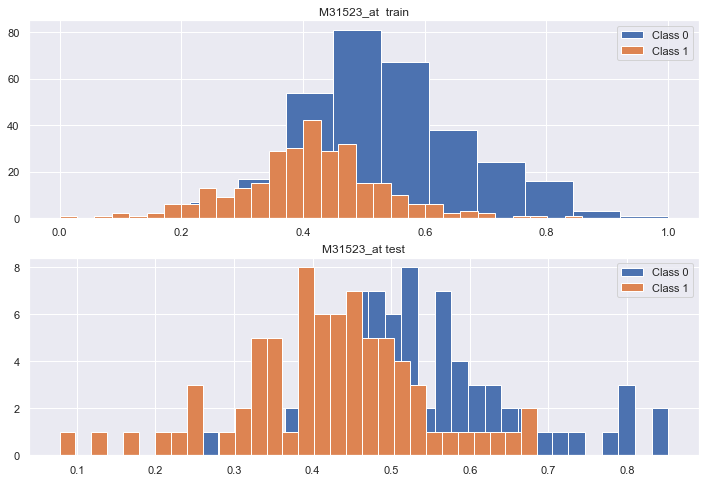

In [8]:
#your code here
plt.figure(figsize=(12,8))
plt.subplot(211)
plt.hist( X_train[y_train==0][best_pred], bins=10, label='Class 0')
plt.hist( X_train[y_train==1][best_pred],bins=30, label='Class 1')
plt.title(best_pred + "  train")
plt.legend()
plt.subplot(212)
plt.hist( X_test[y_test==0][best_pred], bins=30,label='Class 0')
plt.hist( X_test[y_test==1][best_pred], bins=30, label='Class 1')
plt.title(best_pred + " test")
plt.legend();

In [9]:
# #your code here
# from scipy.stats import ttest_ind

# predictors = df.columns
# predictors = predictors.drop('Cancer_type');
# print(predictors.shape) 

# t_tests = ttest_ind(X_train[y_train==0],X_train[y_train==1],equal_var=False)
# best_preds_idx_t_tests = np.argsort(t_tests.pvalue)

# predictors[best_preds_idx_t_tests][0:15]

# # (7129,)
# # Index(['M31523_at', 'X95735_at', 'M84526_at', 'X61587_at', 'U50136_rna1_at',
# #        'X17042_at', 'U29175_at', 'Y08612_at', 'Z11793_at', 'J04615_at',
# #        'X76648_at', 'U72936_s_at', 'M80254_at', 'M29551_at', 'X62320_at'],
# #       dtype='object')

**1.4 Using your most useful gene from the previous part, create a classification model by simply eye-balling a value for this gene that would discriminate the two classes the best (do not use an algorithm to determine for you the optimal coefficient or threshold; we are asking you to provide a rough estimate / model by manual inspection). Justify your choice in 1-2 sentences. Report the accuracy of your hand-chosen model on the test set (write code to implement and evaluate your hand-created model)**


In [10]:
#your code here
threshold = 0.45

train_score = accuracy_score(y_train.values, X_train[best_pred]<=threshold) #Check this!
test_score = accuracy_score(y_test.values, X_test[best_pred]<=threshold)
results = [['naive train', train_score], ['naive test', test_score]] 
  

df_res = pd.DataFrame.from_dict(results)
df_res

,0,1
0,naive train,0.703827
1,naive test,0.688742


By observing the distribution of 'M31523_at' in the training histogram above, we roughly estimate that 0.45 distinguishes the two classes, so we use the threshold of 0.45. 

<div class='exercise'><b> Question 2 [25 pts]: Linear and Logistic Regression  </b></div>

In class, we discussed how to use both linear regression and logistic regression for classification. For this question, you will explore these two models by working with the single gene that you identified above as being the best predictor.

**2.1** Fit a simple linear regression model to the training set using the single gene predictor "best_predictor" to predict cancer type (use the normalized values of the gene). We could interpret the scores predicted by the regression model for a patient as being an estimate of the probability that the patient has Cancer_type=1 (AML). Is this a reasonable interpretation? If not, what is the problem with such?

Create a figure with the following items displayed on the same plot (Use training data):
 - the model's predicted value (the quantitative response from your linear regression model as a function of the normalized value of the best gene predictor)
 - the true binary response. 

**2.2** Use your estimated linear regression model to classify observations into 0 and 1 using the standard Bayes classifier. Evaluate the classification accuracy of this classification model on both the training and testing sets.

**2.3** Next, fit a simple logistic regression model to the training set. How do the training and test classification accuracies of this model compare with the linear regression model? 

Remember, you need to set the regularization parameter for sklearn's logistic regression function to be a very large value in order to **not** regularize (use 'C=100000'). 


**2.4** 
Print and interpret Logistic regression coefficient and intercept. 


Create 2 plots (with training and testing data) with 4 items displayed on each plot.
- the quantitative response from the linear regression model as a function of the best gene predictor.
- the predicted probabilities of the logistic regression model as a function of the best gene predictor. 
- the true binary response. 
- a horizontal line at $y=0.5$. 

Based on these plots, does one of the models appear better suited for binary classification than the other?  Explain in 3 sentences or fewer. 



<hr>

### Solutions

**2.1 Fit a simple linear regression model to the training set using the single gene predictor "best_predictor" to predict cancer type (use the normalized values of the gene). We could interpret the scores predicted by the regression model for a patient as being an estimate of the probability that the patient has Cancer_type=1 (AML). Is this a reasonable interpretation? If not, what is the problem with such?**

**Create a figure with the following items displayed on the same plot (Use training data):**
 - the model's predicted value (the quantitative response from your linear regression model as a function of the normalized value of the best gene predictor)
 - the true binary response.

In [11]:
# your code here
print(best_pred)

linreg = LinearRegression()
linreg.fit(X_train[best_pred].values.reshape(-1,1), y_train)

y_train_pred = linreg.predict(X_train[best_pred].values.reshape(-1,1))
y_test_pred = linreg.predict(X_test[best_pred].values.reshape(-1,1))


M31523_at


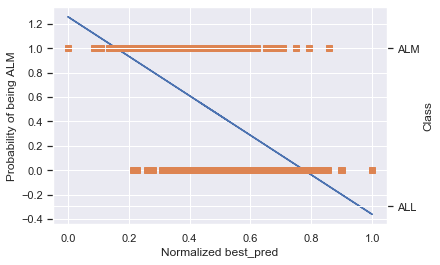

In [12]:
# your code here
fig = plt.figure();
host = fig.add_subplot(111)
par1 = host.twinx()

host.set_ylabel("Probability")
par1.set_ylabel("Class")

host.plot(X_train[best_pred], y_train_pred, '-');
host.plot(X_train[best_pred], y_train, 's');
host.set_xlabel('Normalized best_pred')
host.set_ylabel('Probability of being ALM')

labels = ['ALL', 'ALM'];

# You can specify a rotation for the tick labels in degrees or with keywords.
par1.set_yticks( [0.082, 0.81]);
par1.set_yticklabels(labels);

*your answer here* 

Yes there is a problem with interpretation -  seems like our probabilities are <0 and >1. 

**2.2 Use your estimated linear regression model to classify observations into 0 and 1 using the standard Bayes classifier. Evaluate the classification accuracy of this classification model on both the training and testing sets.**

In [13]:
# your code here
train_score = accuracy_score(y_train, y_train_pred>0.5)
test_score = accuracy_score(y_test, y_test_pred>0.5)

print("train score:", train_score, "test score:", test_score)
df_res = df_res.append([['Linear Regression train', train_score], ['Linear Regression test', test_score]] )
df_res

train score: 0.7088186356073212 test score: 0.6887417218543046


,0,1
0,naive train,0.703827
1,naive test,0.688742
0,Linear Regression train,0.708819
1,Linear Regression test,0.688742



**2.3** **Next, fit a simple logistic regression model to the training set. How do the training and test classification accuracies of this model compare with the linear regression model? Are the classifications substantially different?  Explain why this is the case.**

**Remember, you need to set the regularization parameter for sklearn's logistic regression function to be a very large value in order to **not** regularize (use 'C=100000').

In [14]:
# your code here
logreg = LogisticRegression(C=100000, solver='lbfgs')
logreg.fit(X_train[[best_pred]], y_train) 

y_train_pred_logreg = logreg.predict(X_train[[best_pred]])
y_test_pred_logreg = logreg.predict(X_test[[best_pred]])

y_train_pred_logreg_prob = logreg.predict_proba(X_train[[best_pred]])[:,1]
y_test_pred_logreg_prob = logreg.predict_proba(X_test[[best_pred]])[:,1]

train_score_logreg = accuracy_score(y_train, y_train_pred_logreg)
test_score_logreg = accuracy_score(y_test, y_test_pred_logreg)

print("train score:", train_score_logreg, "test score:", test_score_logreg)

df_res = df_res.append([['Logistic Regression train', train_score_logreg], ['Logistic Regression test', test_score_logreg]] )
df_res

train score: 0.7071547420965059 test score: 0.7086092715231788


,0,1
0,naive train,0.703827
1,naive test,0.688742
0,Linear Regression train,0.708819
1,Linear Regression test,0.688742
0,Logistic Regression train,0.707155
1,Logistic Regression test,0.708609


*your answer here* 

Results are not significantly different. 

**2.4 Print and interpret Logistic regression coefficient and intercept.**

**Create 2 plots (with training and testing data) with 4 items displayed on each plot.**
- the quantitative response from the linear regression model as a function of the best gene predictor.
- the predicted probabilities of the logistic regression model as a function of the best gene predictor. 
- the true binary response. 
- a horizontal line at $y=0.5$. 

**Based on these plots, does one of the models appear better suited for binary classification than the other?  Explain in 3 sentences or fewer.**


$ \hat{p}(X) = \frac{e^{\hat{\beta_0}+\hat{\beta_1}X_1 } }{1 + e^{\hat{\beta_0}+\hat{\beta_1}X_1 }} $

In [15]:
# your code here
logreg.intercept_, logreg.coef_, -logreg.intercept_/logreg.coef_

(array([4.07730445]), array([[-8.75716206]]), array([[0.46559655]]))

The slope is how steep is the sigmoid function is.  Negative slope indicates probability of predicting y = 1 decreases as X gets larger. The intercept offers an indication of how much right or left shifted the curve (inflection point) is by -intercept/slope: the curve is approx 0.4656 to the right in this case.

In [16]:
print("Intercept:",logreg.intercept_)
prob = logreg.predict_proba(np.array([0]).reshape(-1,1))[0,1] #Predictions when best_pred = 0 
print("When %s is 0, log odds are %.5f "%(best_pred,logreg.intercept_))
print("In other words, we predict `cancer_type` with %.5f probability "%(prob))
#np.exp(4.07730445)/(1+np.exp(4.07730445)) = 0.98333


Intercept: [4.07730445]
When M31523_at is 0, log odds are 4.07730 
In other words, we predict `cancer_type` with 0.98333 probability 


In [17]:
print("Coefficient: ",logreg.coef_) 

print("A one-unit increase in coefficient (%s) is associated with an increase in the odds of `cancer_type` by %.5f"%(best_pred,np.exp(logreg.coef_)))
 

#print("A one-unit increase in coefficient (%s) is associated with an increase in the log odds of `cancer_type` by %.5f"%(best_pred,logreg.coef_))
#Explanation 
# #Assume best_pred = 0.48
# prob = logreg.predict_proba(np.array([0.48]).reshape(-1,1))[0,1]
# print("Prob. when best_pred is 0.48 = ",prob)  
# print("Log odds  when best_pred is 0.48 = ", np.log(prob/(1-prob)))

# #Increase best_pred by 1, best_pred = 1.48
# prob1 = logreg.predict_proba(np.array([1.48]).reshape(-1,1))[0,1]
# print("Prob. when best_pred is 1.48 = ",prob1)  
# print("Log odds  when best_pred is 1.48 = ", np.log(prob1/(1-prob1)))

# np.log(prob1/(1-prob1)) - (np.log(prob/(1-prob))) #coefficient

Coefficient:  [[-8.75716206]]
A one-unit increase in coefficient (M31523_at) is associated with an increase in the odds of `cancer_type` by 0.00016


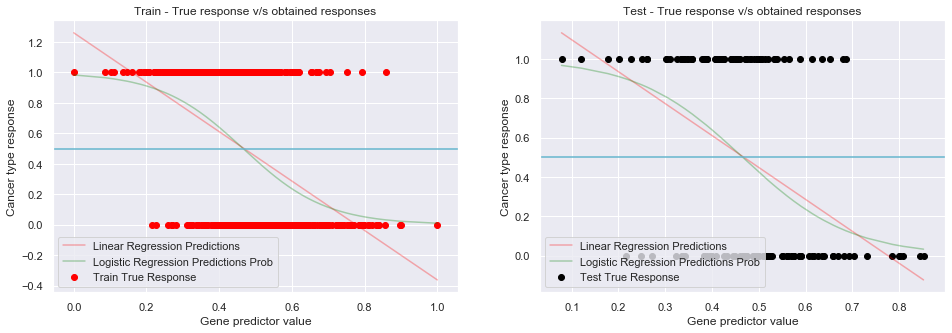

In [18]:
# your code here  
fig, ax = plt.subplots(1,2, figsize=(16,5))
sort_index = np.argsort(X_train[best_pred].values)

# plotting true binary response
ax[0].scatter(X_train[best_pred].iloc[sort_index].values, y_train.iloc[sort_index].values, color='red', label = 'Train True Response')
# plotting ols output
ax[0].plot(X_train[best_pred].iloc[sort_index].values, y_train_pred[sort_index], color='red', alpha=0.3, \
         label = 'Linear Regression Predictions')
# plotting logreg prob output
ax[0].plot(X_train[best_pred].iloc[sort_index].values, y_train_pred_logreg_prob[sort_index], alpha=0.3,  \
         color='green', label = 'Logistic Regression Predictions Prob')

ax[0].axhline(0.5, c='c')
ax[0].legend()
ax[0].set_title('Train - True response v/s obtained responses')
ax[0].set_xlabel('Gene predictor value')
ax[0].set_ylabel('Cancer type response');

# Test
sort_index = np.argsort(X_test[best_pred].values)

# plotting true binary response
ax[1].scatter(X_test[best_pred].iloc[sort_index].values, y_test.iloc[sort_index].values, color='black', label = 'Test True Response')

# plotting ols output
ax[1].plot(X_test[best_pred].iloc[sort_index].values, y_test_pred[sort_index], color='red', alpha=0.3, \
         label = 'Linear Regression Predictions')

# plotting logreg prob output
ax[1].plot(X_test[best_pred].iloc[sort_index].values, y_test_pred_logreg_prob[sort_index], alpha=0.3,  \
         color='green', label = 'Logistic Regression Predictions Prob')

ax[1].axhline(0.5, c='c')
ax[1].legend()
ax[1].set_title('Test - True response v/s obtained responses')
ax[1].set_xlabel('Gene predictor value')
ax[1].set_ylabel('Cancer type response');

Logistic Regression is better suited for this problem, our probabilities are within the range as expected. 

<div class='exercise'> <b> Question 3 [20pts]: Multiple Logistic Regression </b> </div>


**3.1** Next, fit a multiple logistic regression model with **all** the gene predictors from the data set (reminder: for this assignment, we are always using the normalized values). How does the classification accuracy of this model compare with the models fitted in question 2 with a single gene (on both the training and test sets)?  


**3.2** How many of the coefficients estimated by this multiple logistic regression in the previous part (P3.1) are significantly different from zero at a *significance level of 5%*? Use the same value of C=100000 as before.

**Hint:** To answer this question, use *bootstrapping* with 100 bootstrap samples/iterations.  


**3.3** Comment on the classification accuracy of both the training and testing set. Given the results above, how would you assess the generalization capacity of your trained model? What other tests would you suggest to better guard against possibly having a false sense of the overall efficacy/accuracy of the model as a whole?

**3.4** Now let's use regularization to improve the predictions from the multiple logistic regression model. Specifically, use LASSO-like regularization and cross-validation to train the model on the training set. Report the classification accuracy on both the training and testing set.

**3.5** Do the 10 best predictors from Q1 hold up as important features in this regularized model?  If not, explain why this is the case (feel free to use the data to support your explanation).

<hr>
### Solutions

**3.1 Next, fit a multiple logistic regression model with all the gene predictors from the data set (reminder: for this assignment, we are always using the normalized values). How does the classification accuracy of this model compare with the models fitted in question 2 with a single gene (on both the training and test sets)?**  


In [19]:
# your code here
# fitting multi regression model
multi_regr = LogisticRegression(C=100000, solver = "lbfgs", max_iter=10000, random_state=109)
multi_regr.fit(X_train, y_train)

# predictions
y_train_pred_multi = multi_regr.predict(X_train) 
y_test_pred_multi = multi_regr.predict(X_test)

# accuracy
train_score_multi = accuracy_score(y_train, y_train_pred_multi)
test_score_multi = accuracy_score(y_test, y_test_pred_multi)

print('Training set accuracy for multiple logistic regression = ', train_score_multi)
print('Test set accuracy for multiple logistic regression = ', test_score_multi)

df_res = df_res.append([['Multiple Logistic Regression train', train_score_multi],
                        ['Multiple Logistic Regression test', test_score_multi]] )
df_res

Training set accuracy for multiple logistic regression =  1.0
Test set accuracy for multiple logistic regression =  0.7682119205298014


,0,1
0,naive train,0.703827
1,naive test,0.688742
0,Linear Regression train,0.708819
1,Linear Regression test,0.688742
0,Logistic Regression train,0.707155
1,Logistic Regression test,0.708609
0,Multiple Logistic Regression train,1.000000
1,Multiple Logistic Regression test,0.768212


*your answer here* 

Better results, overfitted model.

**3.2** **How many of the coefficients estimated by this multiple logistic regression in the previous part (P3.1) are significantly different from zero at a *significance level of 5%*? Use the same value of C=100000 as before.**

**Hint:** To answer this question, use *bootstrapping* with 100 bootstrap samples/iterations.  

In [20]:
# your code here
# bootstrapping code
n = 100 # Number of iterations
boot_coefs = np.zeros((X_train.shape[1],n)) # Create empty storage array for later use

# iteration for each sample
for i in range(n):
    
    # Sampling WITH replacement the indices of a resampled dataset 
    sample_index = np.random.choice(range(y_train.shape[0]), size=y_train.shape[0], replace=True)

    # finding subset
    x_train_samples = X_train.values[sample_index]
    y_train_samples = y_train.values[sample_index]
    
    # finding logreg coefficient
    logistic_mod_boot = LogisticRegression(C=100000, fit_intercept=True, solver = "lbfgs", max_iter=10000) 
    logistic_mod_boot.fit(x_train_samples, y_train_samples) 
    boot_coefs[:,i] = logistic_mod_boot.coef_

In [21]:
# your code here

ci_upper = np.percentile(boot_coefs, 97.5, axis=1)
ci_lower = np.percentile(boot_coefs, 2.5, axis=1)

# ct significant predictors
sig_b_ct = 0
sig_preds = []
cols = list(X_train.columns)

# if ci contains 0, then insignificant
for i in range(len(ci_upper)):
    if ci_upper[i]<0 or ci_lower[i]>0:
            sig_b_ct += 1
            sig_preds.append(cols[i])

print("Significant coefficents at 5pct level = %i / %i" % (sig_b_ct, len(ci_upper)))
# print('Number of significant columns: ', len(sig_preds))

Significant coefficents at 5pct level = 1194 / 7129


**3.3 Comment on the classification accuracy of both the training and testing set. Given the results above, how would you assess the generalization capacity of your trained model? What other tests would you suggest to better guard against possibly having a false sense of the overall efficacy/accuracy of the model as a whole?**

*your answer here*

Proper cross validation and/or regularization.

**3.4 Now let's use regularization to improve the predictions from the multiple logistic regression model. Specifically, use LASSO-like regularization and cross-validation to train the model on the training set. Report the classification accuracy on both the training and testing set.**

In [22]:
# your code here
# fitting regularized multi regression model - L1 penalty
# Any reason for using liblinear  - Use 5 fold CV
multi_regr = LogisticRegressionCV( solver='liblinear', penalty='l1', cv=5)
multi_regr.fit(X_train, y_train)

# predictions
y_train_pred_multi = multi_regr.predict(X_train) 
y_test_pred_multi = multi_regr.predict(X_test)

# accuracy
train_score_multi = accuracy_score(y_train, y_train_pred_multi)
test_score_multi = accuracy_score(y_test, y_test_pred_multi)

print('Training set accuracy for multiple logistic regression = ', train_score_multi)
print('Test set accuracy for multiple logistic regression = ', test_score_multi)

df_res = df_res.append([['Reg-loR train', train_score_multi], ['Reg-loR val', test_score_multi]] )
df_res

Training set accuracy for multiple logistic regression =  0.9101497504159733
Test set accuracy for multiple logistic regression =  0.8609271523178808


,0,1
0,naive train,0.703827
1,naive test,0.688742
0,Linear Regression train,0.708819
1,Linear Regression test,0.688742
0,Logistic Regression train,0.707155
1,Logistic Regression test,0.708609
0,Multiple Logistic Regression train,1.000000
1,Multiple Logistic Regression test,0.768212
0,Reg-loR train,0.910150
1,Reg-loR val,0.860927


**3.5 Do the 10 best predictors from Q1 hold up as important features in this regularized model?  If not, explain why this is the case (feel free to use the data to support your explanation).**

In [23]:
# your code here
best_pred_1_3 = set(t_tests.index[best_preds_idx[0:10]])
print(best_pred_1_3)

{'U50136_rna1_at', 'X17042_at', 'U29175_at', 'Y08612_at', 'M31523_at', 'Z11793_at', 'X61587_at', 'M84526_at', 'X76648_at', 'X95735_at'}


In [24]:
# your code here
multi_regr_coefs =multi_regr.coef_!=0
#Followin is a list of Lasso coefficients and # of Log Reg L1 coefficients
predictors[multi_regr_coefs[0]] , np.sum(multi_regr_coefs[0])  

(Index(['AFFX-DapX-3_at', 'AF015950_at', 'D26135_at', 'D28416_at', 'D42043_at',
        'D79998_at', 'D86975_at', 'D87457_at', 'HG1869-HT1904_at',
        'HG3993-HT4263_at', 'HG831-HT831_at', 'J04444_at', 'L05148_at',
        'L25851_at', 'L41559_at', 'L76703_at', 'L78833_cds2_at', 'M14016_at',
        'M16038_at', 'M19507_at', 'M20218_at', 'M27891_at', 'M31303_rna1_at',
        'M37815_cds1_at', 'M68895_rna1_at', 'M69023_at', 'M80254_at',
        'M84526_at', 'M86737_at', 'S55606_at', 'U02493_at', 'U10868_at',
        'U17280_at', 'U19878_at', 'U28687_at', 'U43586_at', 'U46499_at',
        'U50136_rna1_at', 'U53468_at', 'U60521_at', 'U77604_at', 'U91316_at',
        'X07109_at', 'X53331_at', 'X59350_at', 'X60484_at', 'X60992_at',
        'X61587_at', 'X62535_at', 'X63753_at', 'X69150_at', 'X70297_at',
        'X71348_at', 'X71973_at', 'X82068_at', 'X83572_at', 'X95735_at',
        'X98172_at', 'Y07604_at', 'Z11793_at', 'Z21966_at', 'Z48054_at',
        'Z93784_at', 'HG2846-HT2983_at'

In [25]:
# your code here
best_pred_1_3.difference(predictors[multi_regr_coefs[0]]) 
#Following predictors were important using t-test, however not for Log Reg - L1.

{'X17042_at', 'X76648_at', 'Y08612_at'}

In [26]:
# your code here
#checking correlation between above list and best predictor
df[['X17042_at', 'X76648_at', 'Y08612_at','M31523_at']].corr().style.background_gradient(cmap='Blues')


,X17042_at,X76648_at,Y08612_at,M31523_at
X17042_at,1,-0.358066,-0.396514,-0.313124
X76648_at,-0.358066,1,0.417654,0.495989
Y08612_at,-0.396514,0.417654,1,0.382711
M31523_at,-0.313124,0.495989,0.382711,1


*your answer here* 

Idea here is that the predictors that did not make it to the list of regularization ... are the ones strongly correlated with the the best predictor. Notice high (absolute) correlation values in last row / last column.


<div class='exercise'> <b> Question 4 [25pts]: Multiclass Logistic Regression </b> </div>

**4.1** Load the data `hw4_mc_enhance.csv.zip` and examine its structure. How many instances of each class are there in our dataset? 

**4.2** Split the dataset into train and test, 80-20 split, random_state = 8. 

We are going to use two particular features/predictors -- 'M31523_at', 'X95735_at'. Create a scatter plot of these two features using training set. We should be able to discern from the plot which sample belongs to which `cancer_type`.

**4.3** Fit the following two models using cross-validation: 
- Logistic Regression Multiclass model with linear features. 
- Logistic Regression Multiclass model with Polynomial features, degree = 2.

**4.4** Plot the decision boundary and interpret results. **Hint:** You may utilize the function `overlay_decision_boundary` 

**4.5** Report and plot the CV scores for the two models and interpret the results.


<hr>
### Solutions

**4.1 Load the data `hw4_mc_enhance.csv.zip` and examine its structure. How many instances of each class are there in our dataset?**

In [27]:
#your code here
zf = zipfile.ZipFile('data/hw4_mc_enhance.csv.zip') 
df = pd.read_csv(zf.open('hw4_mc_enhance.csv'))
display(df.describe())
display(df.head())


,Unnamed: 0,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,...,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at,cancer_type
count,750.00000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,...,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000,750.000000
mean,374.50000,-1014.598658,-1048.357272,-823.358695,-315.636838,-1295.949886,-1625.120199,-826.955064,-1175.612555,-588.598064,...,812.768978,-747.263549,16.272227,-801.847334,1031.081628,-3.162310,-723.364564,-40.495922,-810.150889,1.000000
std,216.65064,297.369331,233.933609,392.662256,215.534283,320.799277,419.687380,562.688520,288.546511,227.362605,...,663.320928,176.481127,751.988770,157.068732,966.569338,495.241653,138.805059,882.681724,176.347552,0.817041
min,0.00000,-2010.202020,-1772.451092,-1619.756151,-930.821077,-1984.530972,-2514.619404,-2766.759937,-1725.591441,-1255.146509,...,-375.241836,-1484.465401,-853.838447,-1367.829068,-571.900054,-838.747726,-1162.232820,-1266.486530,-1298.638023,0.000000
25%,187.25000,-1141.429466,-1218.887728,-1076.151552,-454.824979,-1548.108060,-1848.322368,-1203.978707,-1371.756006,-718.014815,...,322.566010,-847.468558,-335.783011,-924.099294,337.355440,-356.629007,-820.617263,-435.750013,-933.182073,0.000000
50%,374.50000,-1033.862143,-1024.510062,-896.612263,-255.321214,-1257.060242,-1701.504007,-875.340089,-1138.486182,-586.848142,...,639.993676,-750.170322,-130.115409,-783.870080,777.827303,-180.519462,-733.242628,-261.276132,-816.239345,1.000000
75%,561.75000,-837.607536,-885.604686,-560.246417,-196.687009,-1092.191607,-1259.153655,-508.663556,-978.433566,-416.287415,...,1355.814050,-654.438425,117.823076,-706.793736,1571.382500,209.283781,-609.175359,36.278669,-708.453545,2.000000
max,749.00000,-385.768608,-477.363374,130.829434,257.521293,-304.800847,-850.745403,929.737460,-466.326738,196.149024,...,2482.375600,-230.208352,5082.744968,-428.086002,4221.275650,1363.790953,-427.657222,5845.204223,-268.531949,2.000000


,Unnamed: 0,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,...,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at,cancer_type
0,0,-1363.276427,-1058.585495,-541.469194,74.349803,-1110.082554,-1545.661845,-2037.029616,-1255.990888,-335.480958,...,1565.618803,-485.680714,-170.261227,-919.114293,1675.050053,389.769289,-526.449219,-268.963924,-779.643092,0.0
1,1,-796.285053,-1167.103365,7.538493,83.544731,-1116.432539,-1731.392100,249.376523,-1636.960108,-149.080421,...,622.498054,-1275.354673,214.828233,-750.220666,-441.589276,9.841713,-671.911209,-671.911209,-644.272577,0.0
2,2,-679.139168,-1069.832308,-690.301829,-112.075981,-1199.319178,-1286.387935,-605.465604,-1043.041921,-728.254877,...,162.525483,-692.534361,517.498108,-674.674103,1265.396405,-65.192805,-714.859684,3672.066149,-822.021231,0.0
3,3,-1164.400197,-1109.939891,-990.127218,-238.574994,-1264.607160,-1218.860503,-1255.893511,-1009.732928,-521.768585,...,-31.625831,-621.975549,-458.594630,-630.689198,937.767618,-264.715941,-635.046022,475.944222,-794.070116,0.0
4,4,-1299.653758,-1401.998536,-1077.543813,-437.344560,-1386.755697,-1726.453259,-1499.988218,-1219.084464,-994.796971,...,383.591216,-905.517483,-36.675640,-1116.739685,316.087213,-210.879518,-953.423549,-291.448812,-1057.945876,0.0


In [28]:
#your code here 
print(df.columns)


Index(['Unnamed: 0', 'AFFX-BioB-5_at', 'AFFX-BioB-M_at', 'AFFX-BioB-3_at',
       'AFFX-BioC-5_at', 'AFFX-BioC-3_at', 'AFFX-BioDn-5_at',
       'AFFX-BioDn-3_at', 'AFFX-CreX-5_at', 'AFFX-CreX-3_at',
       ...
       'U58516_at', 'U73738_at', 'X06956_at', 'X16699_at', 'X83863_at',
       'Z17240_at', 'L49218_f_at', 'M71243_f_at', 'Z78285_f_at',
       'cancer_type'],
      dtype='object', length=7131)


In [29]:
#How many instances of each class are there in our dataset ? 
print(df.cancer_type.value_counts())

2.0    250
1.0    250
0.0    250
Name: cancer_type, dtype: int64


**4.2 Split the dataset into train and test, 80-20 split, random_state = 8.**

**We are going to utilize these two features - 'M31523_at', 'X95735_at'.  Create a scatter plot of these two features using training dataset.  We should be able to discern from the plot which sample belongs to which `cancer_type`.** 

In [30]:
# your code here
# Split data
from sklearn.model_selection import train_test_split
random_state = 8 

data_train, data_test = train_test_split(df, test_size=.2, random_state=random_state)

data_train_X = data_train[best_preds[0:2]]
data_train_Y = data_train['cancer_type']

# your code here
print(best_preds[0:2])

Index(['M31523_at', 'X95735_at'], dtype='object')


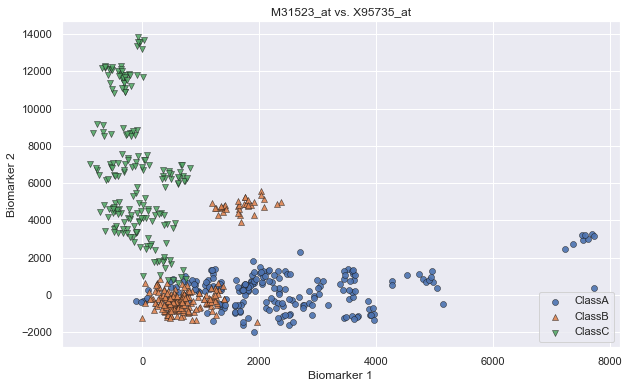

In [31]:
# your code here
X = data_train_X.values
y = data_train_Y.values

pal = sns.utils.get_color_cycle()
class_colors = {0: pal[0], 1: pal[1], 2: pal[2]}
class_markers = {0: 'o', 1: '^', 2: 'v'}
class_names = {"ClassA": 0, "ClassB": 1, "ClassC": 2}
def plot_cancer_data(ax, X, y):
    for class_name, response in class_names.items():
        subset = X[y == response]
        ax.scatter(
            subset[:, 0],
            subset[:, 1], 
            label=class_name,
            alpha=.9, color=class_colors[response],
            lw=.5, edgecolor='k', marker=class_markers[response])
        
        ax.set(xlabel='Biomarker 1', ylabel='Biomarker 2')
        ax.legend(loc="lower right")

fig, ax = plt.subplots(figsize=(10,6))
ax.set_title( 'M31523_at vs. X95735_at')
plot_cancer_data(ax, X, y)

**4.3  Fit the following two models using crossvalidation:**

**Logistic Regression Multiclass model with linear features.**

**Logistic Regression Multiclass model with Polynomial features, degree = 2.**


In [32]:
# your code here
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

polynomial_logreg_estimator = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False),
    LogisticRegressionCV(multi_class="ovr"))

# Since this is a Pipeline, you can call `.fit` and `.predict` just as if it were any other estimator.
#
# Note that you can access the logistic regression classifier itself by
# polynomial_logreg_estimator.named_steps['logisticregressioncv']

In [33]:
# your code here
standardize_before_logreg = True
if not standardize_before_logreg:
    # without standardizing...
    logreg_ovr = LogisticRegressionCV(multi_class="ovr", cv=5, max_iter=300).fit(X, y)
    polynomial_logreg_estimator = make_pipeline(
        PolynomialFeatures(degree=2, include_bias=False),
        LogisticRegressionCV(multi_class="ovr", cv=5, max_iter=300)).fit(X, y);

else:
    # with standardizing... since we want to standardize all features, it's really this easy:
    logreg_ovr = make_pipeline(
        StandardScaler(),
        LogisticRegressionCV(multi_class="ovr", cv=5, max_iter=300)).fit(X, y)
    polynomial_logreg_estimator = make_pipeline(
        PolynomialFeatures(degree=2, include_bias=False),
        StandardScaler(),
        LogisticRegressionCV(multi_class="ovr", cv=5)).fit(X, y);

**4.4 Plot the decision boundary and interpret results. Hint: You may utilize the function `overlay_decision_boundary`** 


In [34]:
def overlay_decision_boundary(ax, model, colors=None, nx=200, ny=200, desaturate=.5, xlim=None, ylim=None):
    """
    A function that visualizes the decision boundaries of a classifier.
    
    ax: Matplotlib Axes to plot on
    model: Classifier to use.
     - if `model` has a `.predict` method, like an sklearn classifier, we call `model.predict(X)`
     - otherwise, we simply call `model(X)`
    colors: list or dict of colors to use. Use color `colors[i]` for class i.
     - If colors is not provided, uses the current color cycle
    nx, ny: number of mesh points to evaluated the classifier on
    desaturate: how much to desaturate each of the colors (for better contrast with the sample points)
    xlim, ylim: range to plot on. (If the default, None, is passed, the limits will be taken from `ax`.)
    """
    # Create mesh.
    xmin, xmax = ax.get_xlim() if xlim is None else xlim
    ymin, ymax = ax.get_ylim() if ylim is None else ylim
    xx, yy = np.meshgrid(
        np.linspace(xmin, xmax, nx),
        np.linspace(ymin, ymax, ny))
    X = np.c_[xx.flatten(), yy.flatten()]

    # Predict on mesh of points.
    model = getattr(model, 'predict', model)
    y = model(X)
    #print("Do I predict" , y)
    
    
#     y[np.where(y=='aml')]=3
#     y[np.where(y=='allT')]=2
#     y[np.where(y=='allB')]=1
    
    
    
    y = y.astype(int) # This may be necessary for 32-bit Python.
    y = y.reshape((nx, ny))

    # Generate colormap.
    if colors is None:
        # If colors not provided, use the current color cycle.
        # Shift the indices so that the lowest class actually predicted gets the first color.
        # ^ This is a bit magic, consider removing for next year.
        colors = (['white'] * np.min(y)) + sns.utils.get_color_cycle()

    if isinstance(colors, dict):
        missing_colors = [idx for idx in np.unique(y) if idx not in colors]
        assert len(missing_colors) == 0, f"Color not specified for predictions {missing_colors}."

        # Make a list of colors, filling in items from the dict.
        color_list = ['white'] * (np.max(y) + 1)
        for idx, val in colors.items():
            color_list[idx] = val
    else:
        assert len(colors) >= np.max(y) + 1, "Insufficient colors passed for all predictions."
        color_list = colors
    color_list = [sns.utils.desaturate(color, desaturate) for color in color_list]
    cmap = matplotlib.colors.ListedColormap(color_list)

    # Plot decision surface
    ax.pcolormesh(xx, yy, y, zorder=-2, cmap=cmap, norm=matplotlib.colors.NoNorm(), vmin=0, vmax=y.max() + 1)
    xx = xx.reshape(nx, ny)
    yy = yy.reshape(nx, ny)
    if len(np.unique(y)) > 1:
        ax.contour(xx, yy, y, colors="black", linewidths=1, zorder=-1)
    else:
        print("Warning: only one class predicted, so not plotting contour lines.")

In [35]:
# Your code here
def plot_decision_boundary(x, y, model, title, ax):
    plot_cancer_data(ax, x, y)
    overlay_decision_boundary(ax, model, colors=class_colors)
    ax.set_title(title)


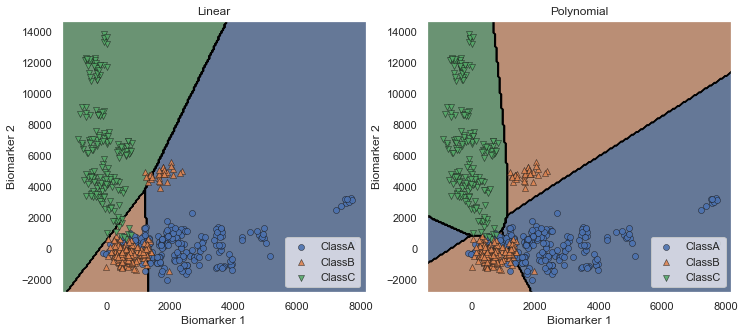

In [36]:
# your code here
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
named_classifiers = [
    ("Linear", logreg_ovr),
    ("Polynomial", polynomial_logreg_estimator)
]
for ax, (name, clf) in zip(axs, named_classifiers):
    plot_decision_boundary(X, y, clf, name, ax)

**4.5 Report and plot the CV scores for the two models and interpret the results.**

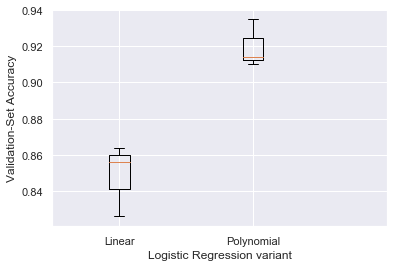

In [37]:
# your code here
cv_scores = [
    cross_val_score(model, X, y, cv=3)
    for name, model in named_classifiers]

plt.boxplot(cv_scores);
plt.xticks(np.arange(1, 4), [name for name, model in named_classifiers])
plt.xlabel("Logistic Regression variant")
plt.ylabel("Validation-Set Accuracy");

In [38]:
# your code here
print("Cross-validation accuracy:")
pd.DataFrame(cv_scores, index=[name for name, model in named_classifiers]).T.aggregate(['mean', 'std']).T

Cross-validation accuracy:


,mean,std
Linear,0.848409,0.019916
Polynomial,0.919971,0.013423


We are looking for low standard deviations in cross validation scores. If standard deviation is low (like in this case), we expect accuracy on an unseen dataset/test datasets to be rougly equal to mean cross validation accuracy. 

<div class='exercise'><b> Question 5: [10 pts] Including an 'abstain' option </b></div>

One of the reasons a hospital might be hesitant to use your cancer classification model is that a misdiagnosis by the model on a patient can sometimes prove to be very costly (e.g., missing a diagnosis or wrongly diagnosing a condition, and subsequently, one may file a lawsuit seeking a compensation for damages). One way to mitigate this concern is to allow the model to 'abstain' from making a prediction whenever it is uncertain about the diagnosis for a patient. However, when the model abstains from making a prediction, the hospital will have to forward the patient to a specialist, which would incur additional cost. How could one design a cancer classification model with an abstain option, such that the cost to the hospital is minimized?

**Hint:** Think of ways to build on top of the logistic regression model and have it abstain on patients who are difficult to classify.

**5.1** More specifically, suppose the cost incurred by a hospital when a model mis-predicts on a patient is $\$5000$ , and the cost incurred when the model abstains from making a prediction is \$1000. What is the average cost per patient for the OvR logistic regression model (without quadratic or interaction terms) from **Question 4**.  Note that this needs to be evaluated on the patients in the testing set. 

**5.2** Design a classification strategy (into the 3 groups plus the *abstain* group) that has a low cost as possible per patient (certainly lower cost per patient than the logistic regression model). Give a justification for your approach.

<hr>
### Solutions

**5.1 More specifically, suppose the cost incurred by a hospital when a model mis-predicts on a patient is $\$5000$ , and the cost incurred when the model abstains from making a prediction is \$1000. What is the average cost per patient for the OvR logistic regression model (without quadratic or interaction terms) from Question 4.** <br><bR> Note that this needs to be evaluated on the patients in the testing set. 

*your answer here* 

**Philosophy:** Assuming the OvR logistic regression model, we estimate $p_j$ for $j\in \{1,2,3\}$, the marginal probability of being in each class. `sklearn` handles the normalization for us, although the normalization step is not necessary for the multinomial model since the softmax function is already constrained to sum to 1. 

Following the hint, we will proceed by using the trained OvR logistic regression model to estimate $\hat{p}_j$ and then use the missclassifications to estimate the cost of them. 


In [39]:
data_test.head()

,Unnamed: 0,AFFX-BioB-5_at,AFFX-BioB-M_at,AFFX-BioB-3_at,AFFX-BioC-5_at,AFFX-BioC-3_at,AFFX-BioDn-5_at,AFFX-BioDn-3_at,AFFX-CreX-5_at,AFFX-CreX-3_at,...,U58516_at,U73738_at,X06956_at,X16699_at,X83863_at,Z17240_at,L49218_f_at,M71243_f_at,Z78285_f_at,cancer_type
694,694,-508.759511,-837.458324,-445.837813,-125.088868,-742.445347,-923.159050,369.544276,-659.463036,-541.814354,...,1325.856037,-394.942745,223.155195,-636.161838,949.753661,-79.503089,-623.255984,-184.752179,-319.145786,0.0
407,407,-1124.873709,-999.916690,-945.925308,-92.663192,-1246.474790,-1755.151889,-949.482528,-1327.335281,-1021.768267,...,1241.000063,-921.140073,147.915618,-879.690813,1601.257679,-199.689132,-763.699857,-464.983480,-852.430952,2.0
535,535,-1319.714408,-1261.696819,-921.241742,-586.837972,-1554.056204,-1540.356876,-760.851436,-1253.483929,-838.579586,...,141.169935,-916.607723,1434.307846,-1092.884459,175.952946,-356.082343,-915.988067,-1266.486530,-1001.912831,0.0
78,78,-845.320689,-998.080799,-584.909139,-266.280699,-1030.496411,-1484.891954,-1014.027851,-1079.956639,-395.081089,...,642.117825,-514.641963,125.877584,-565.851700,1712.403134,-275.402960,-594.887488,514.377683,-624.503836,2.0
542,542,-1033.862143,-931.594226,-1483.768944,-190.050404,-1765.754820,-2290.233745,-697.958723,-1630.799889,-433.994036,...,1685.701733,-772.096997,-338.758922,-777.302277,1735.502020,716.758586,-751.595471,-260.090546,-974.584788,1.0


In [40]:
# predict only in two best predictors
dec = logreg_ovr.predict(data_test.loc[:,best_preds[0:2]].values) 
dec = pd.Series(dec).astype('category').cat.codes

# true values in test, our y_test
vl = np.array(data_test.cancer_type.astype('category').cat.codes)

In [41]:
# your code here
def cost(predictions, truth):
    ''' Counts the cost when we have missclassifications in the predictions vs. the truth set.
    Option = -1 is the abstain option and is only relevant when the values include the abstain option, 
    otherwise initial cost defaults to 0 (for question 5.1). 
    
    Arguments: prediction values and true values
    Returns: the numerical cost
    '''
    cost = 1000 * len(predictions[predictions == -1]) # defaults to 0 for 5.1
    true_vals = truth[predictions != -1]              # defaults to truth for 5.1
    
    predicted_vals = predictions[predictions != -1]   # defaults to predictions for 5.1
    
    cost += 5000 * np.sum(true_vals != predicted_vals)
    return cost

In [42]:
print("Cost incurred for OvR Logistic Regression Model without abstain: $", cost(dec,vl)/len(vl))

Cost incurred for OvR Logistic Regression Model without abstain: $ 800.0


**5.2 Design a classification strategy (into the 3 groups plus the *abstain* group) that has a low cost as possible per patient (certainly lower cost per patient than the logistic regression model). Give a justification for your approach.**

Following 5.1, we make the decision to abstain or not based on minimizing the expected cost. 
<br><br>
The expected cost for abstaining is $\$1000$. The expected cost for predicting is $ \$5000 * P(\text{misdiagnosis}) = 5000 * (1 - \hat{p}_k)$ where $k$ is the label of the predicted class. 

So our decision rule is if the cost of making a missdiagnosis is less than the cost of abstaining (expressed by the formula $5000 * (1 - \hat{p}_k) < 1000$), then attempt a prediction. Otherwise, abstain.

In [43]:
# your code here
def decision_rule(lrm_mod,input_data):
    probs = lrm_mod.predict_proba(input_data)
    predicted_class = np.argmax(probs,axis = 1)
    conf = 1.0 - np.max(probs,axis = 1)
    predicted_class[5000*conf > 1000.0] = -1 #Abstain
    return predicted_class
    
inp = data_test.loc[:,best_preds[0:2]].values
dec2 = decision_rule(logreg_ovr,inp)

print("Cost incurred for new model: $", cost(dec2,vl)/len(vl))

Cost incurred for new model: $ 653.3333333333334
